# Assignment 4

### 1. 复习上课内容以及复现课程代码

在本部分，你需要复习上课内容和课程代码后，自己复现课程代码。

In [1]:
import numpy as np

class Node:
    def __init__(self, inputs=[]):
        self.inputs = inputs
        self.outputs = []

        for n in self.inputs:
            n.outputs.append(self)
            # set 'self' node as inbound_nodes's outbound_nodes

        self.value = None

        self.gradients = {}
        # keys are the inputs to this node, and their
        # values are the partials of this node with 
        # respect to that input.
        # \partial{node}{input_i}
        

    def forward(self):
        '''
        Forward propagation. 
        Compute the output value vased on 'inbound_nodes' and store the 
        result in self.value
        '''

        raise NotImplemented
    

    def backward(self):

        raise NotImplemented
        
class Input(Node):
    def __init__(self):
        '''
        An Input node has no inbound nodes.
        So no need to pass anything to the Node instantiator.
        '''
        Node.__init__(self)

    def forward(self, value=None):
        '''
        Only input node is the node where the value may be passed
        as an argument to forward().
        All other node implementations should get the value of the 
        previous node from self.inbound_nodes
        
        Example: 
        val0: self.inbound_nodes[0].value
        '''
        if value is not None:
            self.value = value
            ## It's is input node, when need to forward, this node initiate self's value.

        # Input subclass just holds a value, such as a data feature or a model parameter(weight/bias)
        
    def backward(self):
        self.gradients = {self:0}
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1
            
        
        # input N --> N1, N2
        # \partial L / \partial N 
        # ==> \partial L / \partial N1 * \ partial N1 / \partial N


class Add(Node):
    def __init__(self, *nodes):
        Node.__init__(self, nodes)


    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs))
        ## when execute forward, this node caculate value as defined.

class Linear(Node):
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])

    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value

        self.value = np.dot(inputs, weights) + bias
        
    def backward(self):

        # initial a partial for each of the inbound_nodes.
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            # Get the partial of the cost w.r.t this node.
            grad_cost = n.gradients[self]

            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)

        # WX + B / W ==> X
        # WX + B / X ==> W

class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])


    def _sigmoid(self, x):
        return 1./(1 + np.exp(-1 * x))

    def forward(self):
        self.x = self.inputs[0].value
        self.value = self._sigmoid(self.x)

    def backward(self):
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        
        # y = 1 / (1 + e^-x)
        # y' = 1 / (1 + e^-x) (1 - 1 / (1 + e^-x))
        
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}

        for n in self.outputs:
            grad_cost = n.gradients[self]  # Get the partial of the cost with respect to this node.

            self.gradients[self.inputs[0]] = grad_cost * self.partial
            # use * to keep all the dimension same!.



class MSE(Node):
    def __init__(self, y, a):
        Node.__init__(self, [y, a])


    def forward(self):
        y = self.inputs[0].value.reshape(-1, 1)
        a = self.inputs[1].value.reshape(-1, 1)
        assert(y.shape == a.shape)

        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a

        self.value = np.mean(self.diff**2)


    def backward(self):
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff


def forward_and_backward(outputnode, graph):
    # execute all the forward method of sorted_nodes.

    ## In practice, it's common to feed in mutiple data example in each forward pass rather than just 1. Because the examples can be processed in parallel. The number of examples is called batch size.
    for n in graph:
        n.forward()
        ## each node execute forward, get self.value based on the topological sort result.

    for n in  graph[::-1]:
        n.backward()

    #return outputnode.value

###   v -->  a -->  C
##    b --> C
##    b --> v -- a --> C
##    v --> v ---> a -- > C

def topological_sort(feed_dict):
    """
    Sort generic nodes in topological order using Kahn's Algorithm.
    `feed_dict`: A dictionary where the key is a `Input` node and the value is the respective value feed to that node.
    Returns a list of sorted nodes.
    """

    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]
            ## if n is Input Node, set n'value as 
            ## feed_dict[n]
            ## else, n's value is caculate as its
            ## inbounds

        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L


def sgd_update(trainables, learning_rate=1e-2):
    # there are so many other update / optimization methods
    # such as Adam, Mom, 
    for t in trainables:
        t.value += -1 * learning_rate * t.gradients[t]

In [2]:
from sklearn.datasets import load_boston

In [3]:
data = load_boston()

In [4]:
losses = []

In [5]:
"""
Check out the new network architecture and dataset!
Notice that the weights and biases are
generated randomly.
No need to change anything, but feel free to tweak
to test your network, play around with the epochs, batch size, etc!
"""

import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample
#from miniflow import *

# Load data
data = load_boston()
X_ = data['data']
y_ = data['target']

# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

# Neural network
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 5000
# Total number of examples
m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))

# Step 4
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        _ = None
        forward_and_backward(_, graph) # set output node not important.

        # Step 3
        rate = 1e-2
    
        sgd_update(trainables, rate)

        loss += graph[-1].value
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Total number of examples = 506
Epoch: 1, Loss: 180.168
Epoch: 101, Loss: 6.351
Epoch: 201, Loss: 6.748
Epoch: 301, Loss: 4.951
Epoch: 401, Loss: 4.983
Epoch: 501, Loss: 5.226
Epoch: 601, Loss: 3.864
Epoch: 701, Loss: 3.789
Epoch: 801, Loss: 3.782
Epoch: 901, Loss: 3.301
Epoch: 1001, Loss: 3.164
Epoch: 1101, Loss: 3.564
Epoch: 1201, Loss: 2.999
Epoch: 1301, Loss: 3.440
Epoch: 1401, Loss: 3.081
Epoch: 1501, Loss: 3.188
Epoch: 1601, Loss: 3.450
Epoch: 1701, Loss: 2.777
Epoch: 1801, Loss: 3.012
Epoch: 1901, Loss: 2.611
Epoch: 2001, Loss: 2.974
Epoch: 2101, Loss: 3.317
Epoch: 2201, Loss: 3.141
Epoch: 2301, Loss: 3.080
Epoch: 2401, Loss: 3.081
Epoch: 2501, Loss: 3.096
Epoch: 2601, Loss: 2.990
Epoch: 2701, Loss: 2.955
Epoch: 2801, Loss: 2.823
Epoch: 2901, Loss: 2.845
Epoch: 3001, Loss: 3.033
Epoch: 3101, Loss: 2.845
Epoch: 3201, Loss: 2.839
Epoch: 3301, Loss: 3.094
Epoch: 3401, Loss: 3.101
Epoch: 3501, Loss: 2.777
Epoch: 3601, Loss: 2.872
Epoch: 3701, Loss: 3.015
Epoch: 3801, Loss: 2.832
Epoc

In [6]:
import matplotlib.pyplot as plt

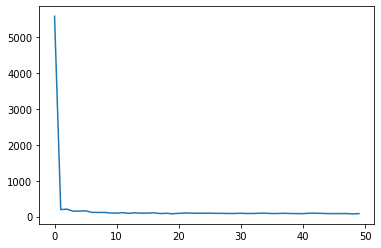

In [7]:
plt.plot(range(len(losses)), losses)

In [8]:
W2.value

array([[ 5.74767557],
       [ 6.64255013],
       [16.23252893],
       [ 8.3544971 ],
       [ 7.24351138],
       [24.48817699],
       [ 5.64640327],
       [ 6.97701025],
       [-4.77696264],
       [ 5.72897834]])

In [9]:
X_ = data['data']

In [10]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [14]:
from tensorflow import keras

In [15]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [19]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

model = Sequential()

model.add(Dense(units=64, activation='sigmoid', input_dim=13))
model.add(Dense(units=30, activation='sigmoid', input_dim=64))
model.add(Dense(units=1))

model.compile(loss='mse',
              optimizer='sgd',
              metrics=['mse'])

In [20]:
model.fit(X_, y_, epochs=5000, batch_size=32)

Train on 506 samples
Epoch 1/5000
506/506 [==============================] - 1s 1ms/sample - loss: 136.3782 - mse: 136.3783
Epoch 2/5000
506/506 [==============================] - 0s 32us/sample - loss: 82.8002 - mse: 82.8002
Epoch 3/5000
506/506 [==============================] - 0s 52us/sample - loss: 83.2551 - mse: 83.2551
Epoch 4/5000
506/506 [==============================] - 0s 32us/sample - loss: 83.5628 - mse: 83.5628
Epoch 5/5000
506/506 [==============================] - 0s 54us/sample - loss: 84.7145 - mse: 84.7145
Epoch 6/5000
506/506 [==============================] - 0s 33us/sample - loss: 82.0899 - mse: 82.0899
Epoch 7/5000
506/506 [==============================] - 0s 55us/sample - loss: 85.5480 - mse: 85.5480
Epoch 8/5000
506/506 [==============================] - 0s 33us/sample - loss: 80.2228 - mse: 80.2228
Epoch 9/5000
506/506 [==============================] - 0s 45us/sample - loss: 77.8850 - mse: 77.8850
Epoch 10/5000
506/506 [==============================] - 0s 

506/506 [==============================] - 0s 47us/sample - loss: 85.4100 - mse: 85.4100
Epoch 81/5000
506/506 [==============================] - 0s 48us/sample - loss: 85.1380 - mse: 85.1380
Epoch 82/5000
506/506 [==============================] - 0s 46us/sample - loss: 85.4727 - mse: 85.4727
Epoch 83/5000
506/506 [==============================] - 0s 44us/sample - loss: 84.7289 - mse: 84.7289
Epoch 84/5000
506/506 [==============================] - 0s 38us/sample - loss: 85.2681 - mse: 85.2681
Epoch 85/5000
506/506 [==============================] - 0s 39us/sample - loss: 85.0336 - mse: 85.0336
Epoch 86/5000
506/506 [==============================] - 0s 38us/sample - loss: 85.0249 - mse: 85.0249
Epoch 87/5000
506/506 [==============================] - 0s 39us/sample - loss: 85.0027 - mse: 85.0027
Epoch 88/5000
506/506 [==============================] - 0s 36us/sample - loss: 84.9554 - mse: 84.9554
Epoch 89/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.8789

506/506 [==============================] - 0s 36us/sample - loss: 85.3934 - mse: 85.3933
Epoch 160/5000
506/506 [==============================] - 0s 37us/sample - loss: 85.1857 - mse: 85.1857
Epoch 161/5000
506/506 [==============================] - 0s 37us/sample - loss: 85.3755 - mse: 85.3755
Epoch 162/5000
506/506 [==============================] - 0s 39us/sample - loss: 85.2235 - mse: 85.2235
Epoch 163/5000
506/506 [==============================] - 0s 39us/sample - loss: 85.9220 - mse: 85.9220
Epoch 164/5000
506/506 [==============================] - 0s 37us/sample - loss: 85.3542 - mse: 85.3542
Epoch 165/5000
506/506 [==============================] - 0s 35us/sample - loss: 85.3662 - mse: 85.3662
Epoch 166/5000
506/506 [==============================] - 0s 36us/sample - loss: 85.2890 - mse: 85.2890
Epoch 167/5000
506/506 [==============================] - 0s 35us/sample - loss: 85.1345 - mse: 85.1345
Epoch 168/5000
506/506 [==============================] - 0s 39us/sample - loss

506/506 [==============================] - 0s 34us/sample - loss: 84.9640 - mse: 84.9640
Epoch 238/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.3262 - mse: 84.3262
Epoch 239/5000
506/506 [==============================] - 0s 41us/sample - loss: 85.7391 - mse: 85.7391
Epoch 240/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.7439 - mse: 84.7439
Epoch 241/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.8960 - mse: 84.8960
Epoch 242/5000
506/506 [==============================] - 0s 37us/sample - loss: 85.0085 - mse: 85.0085
Epoch 243/5000
506/506 [==============================] - 0s 38us/sample - loss: 85.2673 - mse: 85.2673
Epoch 244/5000
506/506 [==============================] - 0s 43us/sample - loss: 84.8262 - mse: 84.8262
Epoch 245/5000
506/506 [==============================] - 0s 37us/sample - loss: 85.2464 - mse: 85.2464
Epoch 246/5000
506/506 [==============================] - 0s 36us/sample - loss

506/506 [==============================] - 0s 42us/sample - loss: 84.7993 - mse: 84.7994
Epoch 316/5000
506/506 [==============================] - 0s 42us/sample - loss: 84.8878 - mse: 84.8878
Epoch 317/5000
506/506 [==============================] - 0s 39us/sample - loss: 85.2295 - mse: 85.2295
Epoch 318/5000
506/506 [==============================] - 0s 37us/sample - loss: 85.3229 - mse: 85.3229
Epoch 319/5000
506/506 [==============================] - 0s 39us/sample - loss: 85.0966 - mse: 85.0966
Epoch 320/5000
506/506 [==============================] - 0s 37us/sample - loss: 85.2180 - mse: 85.2180
Epoch 321/5000
506/506 [==============================] - 0s 35us/sample - loss: 84.5380 - mse: 84.5380
Epoch 322/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.9057 - mse: 84.9057
Epoch 323/5000
506/506 [==============================] - 0s 39us/sample - loss: 85.2511 - mse: 85.2511
Epoch 324/5000
506/506 [==============================] - 0s 41us/sample - loss

506/506 [==============================] - 0s 38us/sample - loss: 84.7041 - mse: 84.7041
Epoch 394/5000
506/506 [==============================] - 0s 36us/sample - loss: 84.8131 - mse: 84.8131
Epoch 395/5000
506/506 [==============================] - 0s 36us/sample - loss: 85.0039 - mse: 85.0039
Epoch 396/5000
506/506 [==============================] - 0s 41us/sample - loss: 85.5196 - mse: 85.5197
Epoch 397/5000
506/506 [==============================] - 0s 35us/sample - loss: 85.1719 - mse: 85.1719
Epoch 398/5000
506/506 [==============================] - 0s 40us/sample - loss: 85.7296 - mse: 85.7296
Epoch 399/5000
506/506 [==============================] - 0s 43us/sample - loss: 85.2656 - mse: 85.2656
Epoch 400/5000
506/506 [==============================] - 0s 40us/sample - loss: 84.5224 - mse: 84.5224
Epoch 401/5000
506/506 [==============================] - 0s 41us/sample - loss: 84.7780 - mse: 84.7780
Epoch 402/5000
506/506 [==============================] - 0s 44us/sample - loss

506/506 [==============================] - 0s 40us/sample - loss: 85.0906 - mse: 85.0906
Epoch 472/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.9368 - mse: 84.9368
Epoch 473/5000
506/506 [==============================] - 0s 37us/sample - loss: 85.0742 - mse: 85.0742
Epoch 474/5000
506/506 [==============================] - 0s 38us/sample - loss: 85.0299 - mse: 85.0299
Epoch 475/5000
506/506 [==============================] - 0s 41us/sample - loss: 85.1042 - mse: 85.1042
Epoch 476/5000
506/506 [==============================] - 0s 41us/sample - loss: 85.6140 - mse: 85.6140
Epoch 477/5000
506/506 [==============================] - 0s 41us/sample - loss: 84.4030 - mse: 84.4030
Epoch 478/5000
506/506 [==============================] - 0s 36us/sample - loss: 85.3635 - mse: 85.3635
Epoch 479/5000
506/506 [==============================] - 0s 39us/sample - loss: 85.4026 - mse: 85.4026
Epoch 480/5000
506/506 [==============================] - 0s 36us/sample - loss

506/506 [==============================] - 0s 35us/sample - loss: 84.9178 - mse: 84.9178
Epoch 550/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.8857 - mse: 84.8857
Epoch 551/5000
506/506 [==============================] - 0s 39us/sample - loss: 84.6662 - mse: 84.6662
Epoch 552/5000
506/506 [==============================] - 0s 44us/sample - loss: 84.9417 - mse: 84.9417
Epoch 553/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.7651 - mse: 84.7651
Epoch 554/5000
506/506 [==============================] - 0s 48us/sample - loss: 85.1077 - mse: 85.1076
Epoch 555/5000
506/506 [==============================] - 0s 41us/sample - loss: 84.5762 - mse: 84.5762
Epoch 556/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.6102 - mse: 84.6102
Epoch 557/5000
506/506 [==============================] - 0s 36us/sample - loss: 84.8626 - mse: 84.8626
Epoch 558/5000
506/506 [==============================] - 0s 40us/sample - loss

506/506 [==============================] - 0s 40us/sample - loss: 84.8397 - mse: 84.8397
Epoch 628/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.4408 - mse: 84.4408
Epoch 629/5000
506/506 [==============================] - 0s 40us/sample - loss: 85.0379 - mse: 85.0379
Epoch 630/5000
506/506 [==============================] - 0s 36us/sample - loss: 85.1672 - mse: 85.1672
Epoch 631/5000
506/506 [==============================] - 0s 34us/sample - loss: 84.6882 - mse: 84.6883
Epoch 632/5000
506/506 [==============================] - 0s 36us/sample - loss: 84.9562 - mse: 84.9562
Epoch 633/5000
506/506 [==============================] - 0s 40us/sample - loss: 85.0921 - mse: 85.0921
Epoch 634/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.6038 - mse: 84.6038
Epoch 635/5000
506/506 [==============================] - 0s 34us/sample - loss: 85.1962 - mse: 85.1962
Epoch 636/5000
506/506 [==============================] - 0s 38us/sample - loss

506/506 [==============================] - 0s 35us/sample - loss: 84.9937 - mse: 84.9937
Epoch 706/5000
506/506 [==============================] - 0s 35us/sample - loss: 84.4423 - mse: 84.4423
Epoch 707/5000
506/506 [==============================] - 0s 45us/sample - loss: 84.7164 - mse: 84.7164
Epoch 708/5000
506/506 [==============================] - 0s 40us/sample - loss: 85.0313 - mse: 85.0313
Epoch 709/5000
506/506 [==============================] - 0s 39us/sample - loss: 85.0263 - mse: 85.0263
Epoch 710/5000
506/506 [==============================] - 0s 36us/sample - loss: 84.9419 - mse: 84.9419
Epoch 711/5000
506/506 [==============================] - 0s 33us/sample - loss: 85.4766 - mse: 85.4766
Epoch 712/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.5620 - mse: 84.5620
Epoch 713/5000
506/506 [==============================] - 0s 36us/sample - loss: 85.0323 - mse: 85.0323
Epoch 714/5000
506/506 [==============================] - 0s 35us/sample - loss

506/506 [==============================] - 0s 34us/sample - loss: 85.2103 - mse: 85.2103
Epoch 784/5000
506/506 [==============================] - 0s 39us/sample - loss: 84.9272 - mse: 84.9272
Epoch 785/5000
506/506 [==============================] - 0s 35us/sample - loss: 84.7524 - mse: 84.7524
Epoch 786/5000
506/506 [==============================] - 0s 42us/sample - loss: 85.7366 - mse: 85.7366
Epoch 787/5000
506/506 [==============================] - 0s 39us/sample - loss: 84.8866 - mse: 84.8866
Epoch 788/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.9045 - mse: 84.9045
Epoch 789/5000
506/506 [==============================] - 0s 41us/sample - loss: 84.8894 - mse: 84.8894
Epoch 790/5000
506/506 [==============================] - 0s 35us/sample - loss: 84.7691 - mse: 84.7691
Epoch 791/5000
506/506 [==============================] - 0s 35us/sample - loss: 85.2647 - mse: 85.2647
Epoch 792/5000
506/506 [==============================] - 0s 34us/sample - loss

506/506 [==============================] - 0s 38us/sample - loss: 84.3409 - mse: 84.3409
Epoch 862/5000
506/506 [==============================] - 0s 46us/sample - loss: 85.7159 - mse: 85.7159
Epoch 863/5000
506/506 [==============================] - 0s 43us/sample - loss: 85.1616 - mse: 85.1616
Epoch 864/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.7484 - mse: 84.7484
Epoch 865/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.7450 - mse: 84.7450
Epoch 866/5000
506/506 [==============================] - 0s 36us/sample - loss: 84.3772 - mse: 84.3772
Epoch 867/5000
506/506 [==============================] - 0s 36us/sample - loss: 85.1857 - mse: 85.1857
Epoch 868/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.5554 - mse: 84.5554
Epoch 869/5000
506/506 [==============================] - 0s 40us/sample - loss: 84.6826 - mse: 84.6826
Epoch 870/5000
506/506 [==============================] - 0s 40us/sample - loss

506/506 [==============================] - 0s 46us/sample - loss: 84.8715 - mse: 84.8715
Epoch 940/5000
506/506 [==============================] - 0s 42us/sample - loss: 84.7879 - mse: 84.7879
Epoch 941/5000
506/506 [==============================] - 0s 38us/sample - loss: 85.0635 - mse: 85.0635
Epoch 942/5000
506/506 [==============================] - 0s 40us/sample - loss: 85.0258 - mse: 85.0258
Epoch 943/5000
506/506 [==============================] - 0s 38us/sample - loss: 85.1777 - mse: 85.1777
Epoch 944/5000
506/506 [==============================] - 0s 33us/sample - loss: 85.0929 - mse: 85.0929
Epoch 945/5000
506/506 [==============================] - 0s 40us/sample - loss: 85.2495 - mse: 85.2495
Epoch 946/5000
506/506 [==============================] - 0s 36us/sample - loss: 85.4783 - mse: 85.4783
Epoch 947/5000
506/506 [==============================] - 0s 34us/sample - loss: 84.8304 - mse: 84.8304
Epoch 948/5000
506/506 [==============================] - 0s 36us/sample - loss

506/506 [==============================] - 0s 37us/sample - loss: 85.0107 - mse: 85.0107
Epoch 1018/5000
506/506 [==============================] - 0s 36us/sample - loss: 84.9679 - mse: 84.9679
Epoch 1019/5000
506/506 [==============================] - 0s 36us/sample - loss: 84.8357 - mse: 84.8357
Epoch 1020/5000
506/506 [==============================] - 0s 34us/sample - loss: 84.6887 - mse: 84.6887
Epoch 1021/5000
506/506 [==============================] - 0s 36us/sample - loss: 84.9972 - mse: 84.9972
Epoch 1022/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.6080 - mse: 84.6080
Epoch 1023/5000
506/506 [==============================] - 0s 43us/sample - loss: 84.8491 - mse: 84.8491
Epoch 1024/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.9710 - mse: 84.9710
Epoch 1025/5000
506/506 [==============================] - 0s 34us/sample - loss: 84.5526 - mse: 84.5526
Epoch 1026/5000
506/506 [==============================] - 0s 37us/samp

506/506 [==============================] - 0s 34us/sample - loss: 84.8983 - mse: 84.8984
Epoch 1096/5000
506/506 [==============================] - 0s 36us/sample - loss: 84.6541 - mse: 84.6541
Epoch 1097/5000
506/506 [==============================] - 0s 41us/sample - loss: 85.2711 - mse: 85.2711
Epoch 1098/5000
506/506 [==============================] - 0s 40us/sample - loss: 84.7559 - mse: 84.7559
Epoch 1099/5000
506/506 [==============================] - 0s 36us/sample - loss: 85.7638 - mse: 85.7638
Epoch 1100/5000
506/506 [==============================] - 0s 45us/sample - loss: 84.7212 - mse: 84.7212
Epoch 1101/5000
506/506 [==============================] - 0s 40us/sample - loss: 85.1178 - mse: 85.1178
Epoch 1102/5000
506/506 [==============================] - 0s 35us/sample - loss: 84.5408 - mse: 84.5408
Epoch 1103/5000
506/506 [==============================] - 0s 39us/sample - loss: 85.3862 - mse: 85.3862
Epoch 1104/5000
506/506 [==============================] - 0s 37us/samp

506/506 [==============================] - 0s 36us/sample - loss: 84.8951 - mse: 84.8951
Epoch 1174/5000
506/506 [==============================] - 0s 35us/sample - loss: 84.7403 - mse: 84.7403
Epoch 1175/5000
506/506 [==============================] - 0s 36us/sample - loss: 84.9792 - mse: 84.9792
Epoch 1176/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.7189 - mse: 84.7189
Epoch 1177/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.8626 - mse: 84.8626
Epoch 1178/5000
506/506 [==============================] - 0s 37us/sample - loss: 85.2909 - mse: 85.2909
Epoch 1179/5000
506/506 [==============================] - 0s 36us/sample - loss: 84.9239 - mse: 84.9239
Epoch 1180/5000
506/506 [==============================] - 0s 39us/sample - loss: 85.8663 - mse: 85.8663
Epoch 1181/5000
506/506 [==============================] - 0s 46us/sample - loss: 85.1597 - mse: 85.1597
Epoch 1182/5000
506/506 [==============================] - 0s 40us/samp

506/506 [==============================] - 0s 38us/sample - loss: 85.0046 - mse: 85.0046
Epoch 1252/5000
506/506 [==============================] - 0s 35us/sample - loss: 85.1533 - mse: 85.1533
Epoch 1253/5000
506/506 [==============================] - 0s 36us/sample - loss: 84.9999 - mse: 84.9999
Epoch 1254/5000
506/506 [==============================] - 0s 43us/sample - loss: 85.7081 - mse: 85.7081
Epoch 1255/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.8607 - mse: 84.8607
Epoch 1256/5000
506/506 [==============================] - 0s 42us/sample - loss: 84.3828 - mse: 84.3829
Epoch 1257/5000
506/506 [==============================] - 0s 40us/sample - loss: 84.9764 - mse: 84.9764
Epoch 1258/5000
506/506 [==============================] - 0s 36us/sample - loss: 85.0868 - mse: 85.0868
Epoch 1259/5000
506/506 [==============================] - 0s 33us/sample - loss: 85.2818 - mse: 85.2818
Epoch 1260/5000
506/506 [==============================] - 0s 36us/samp

506/506 [==============================] - 0s 36us/sample - loss: 85.0961 - mse: 85.0961
Epoch 1330/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.9918 - mse: 84.9918
Epoch 1331/5000
506/506 [==============================] - 0s 43us/sample - loss: 85.4247 - mse: 85.4247
Epoch 1332/5000
506/506 [==============================] - 0s 48us/sample - loss: 84.9078 - mse: 84.9078
Epoch 1333/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.9775 - mse: 84.9775
Epoch 1334/5000
506/506 [==============================] - 0s 35us/sample - loss: 84.7069 - mse: 84.7069
Epoch 1335/5000
506/506 [==============================] - 0s 34us/sample - loss: 84.8900 - mse: 84.8900
Epoch 1336/5000
506/506 [==============================] - 0s 40us/sample - loss: 85.0225 - mse: 85.0225
Epoch 1337/5000
506/506 [==============================] - 0s 43us/sample - loss: 84.9275 - mse: 84.9275
Epoch 1338/5000
506/506 [==============================] - 0s 35us/samp

506/506 [==============================] - 0s 43us/sample - loss: 84.5873 - mse: 84.5873
Epoch 1408/5000
506/506 [==============================] - 0s 36us/sample - loss: 85.3382 - mse: 85.3382
Epoch 1409/5000
506/506 [==============================] - 0s 38us/sample - loss: 85.1887 - mse: 85.1887
Epoch 1410/5000
506/506 [==============================] - 0s 34us/sample - loss: 84.6368 - mse: 84.6368
Epoch 1411/5000
506/506 [==============================] - 0s 36us/sample - loss: 85.0559 - mse: 85.0559
Epoch 1412/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.2911 - mse: 84.2911
Epoch 1413/5000
506/506 [==============================] - 0s 35us/sample - loss: 85.1215 - mse: 85.1215
Epoch 1414/5000
506/506 [==============================] - 0s 40us/sample - loss: 85.1775 - mse: 85.1775
Epoch 1415/5000
506/506 [==============================] - 0s 43us/sample - loss: 83.1545 - mse: 83.1545
Epoch 1416/5000
506/506 [==============================] - 0s 43us/samp

506/506 [==============================] - 0s 34us/sample - loss: 84.9004 - mse: 84.9004
Epoch 1486/5000
506/506 [==============================] - 0s 36us/sample - loss: 84.9263 - mse: 84.9263
Epoch 1487/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.8088 - mse: 84.8088
Epoch 1488/5000
506/506 [==============================] - 0s 40us/sample - loss: 84.6869 - mse: 84.6869
Epoch 1489/5000
506/506 [==============================] - 0s 40us/sample - loss: 84.9619 - mse: 84.9619
Epoch 1490/5000
506/506 [==============================] - 0s 35us/sample - loss: 84.6075 - mse: 84.6075
Epoch 1491/5000
506/506 [==============================] - 0s 40us/sample - loss: 84.8378 - mse: 84.8378
Epoch 1492/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.8913 - mse: 84.8913
Epoch 1493/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.1657 - mse: 84.1656
Epoch 1494/5000
506/506 [==============================] - 0s 37us/samp

506/506 [==============================] - 0s 40us/sample - loss: 84.9019 - mse: 84.9019
Epoch 1564/5000
506/506 [==============================] - 0s 35us/sample - loss: 84.6958 - mse: 84.6958
Epoch 1565/5000
506/506 [==============================] - 0s 37us/sample - loss: 85.4746 - mse: 85.4746
Epoch 1566/5000
506/506 [==============================] - 0s 38us/sample - loss: 85.2674 - mse: 85.2674
Epoch 1567/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.5625 - mse: 84.5625
Epoch 1568/5000
506/506 [==============================] - 0s 35us/sample - loss: 86.0467 - mse: 86.0467
Epoch 1569/5000
506/506 [==============================] - 0s 36us/sample - loss: 84.9094 - mse: 84.9094
Epoch 1570/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.8821 - mse: 84.8821
Epoch 1571/5000
506/506 [==============================] - 0s 35us/sample - loss: 85.0119 - mse: 85.0119
Epoch 1572/5000
506/506 [==============================] - 0s 40us/samp

506/506 [==============================] - 0s 35us/sample - loss: 84.6620 - mse: 84.6620
Epoch 1642/5000
506/506 [==============================] - 0s 35us/sample - loss: 84.8736 - mse: 84.8736
Epoch 1643/5000
506/506 [==============================] - 0s 34us/sample - loss: 84.9537 - mse: 84.9538
Epoch 1644/5000
506/506 [==============================] - 0s 39us/sample - loss: 84.7049 - mse: 84.7049
Epoch 1645/5000
506/506 [==============================] - 0s 41us/sample - loss: 85.3279 - mse: 85.3279
Epoch 1646/5000
506/506 [==============================] - 0s 41us/sample - loss: 84.6728 - mse: 84.6728
Epoch 1647/5000
506/506 [==============================] - 0s 36us/sample - loss: 84.9009 - mse: 84.9009
Epoch 1648/5000
506/506 [==============================] - 0s 41us/sample - loss: 85.1691 - mse: 85.1691
Epoch 1649/5000
506/506 [==============================] - 0s 44us/sample - loss: 85.1498 - mse: 85.1498
Epoch 1650/5000
506/506 [==============================] - 0s 43us/samp

506/506 [==============================] - 0s 35us/sample - loss: 84.7965 - mse: 84.7965
Epoch 1720/5000
506/506 [==============================] - 0s 32us/sample - loss: 84.8954 - mse: 84.8954
Epoch 1721/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.8955 - mse: 84.8955
Epoch 1722/5000
506/506 [==============================] - 0s 39us/sample - loss: 84.7470 - mse: 84.7470
Epoch 1723/5000
506/506 [==============================] - 0s 35us/sample - loss: 85.3980 - mse: 85.3980
Epoch 1724/5000
506/506 [==============================] - 0s 47us/sample - loss: 85.4216 - mse: 85.4216
Epoch 1725/5000
506/506 [==============================] - 0s 42us/sample - loss: 84.8759 - mse: 84.8759
Epoch 1726/5000
506/506 [==============================] - 0s 47us/sample - loss: 84.9123 - mse: 84.9123
Epoch 1727/5000
506/506 [==============================] - 0s 42us/sample - loss: 84.7721 - mse: 84.7721
Epoch 1728/5000
506/506 [==============================] - 0s 35us/samp

506/506 [==============================] - 0s 38us/sample - loss: 85.6390 - mse: 85.6390
Epoch 1798/5000
506/506 [==============================] - 0s 47us/sample - loss: 84.6496 - mse: 84.6496
Epoch 1799/5000
506/506 [==============================] - 0s 41us/sample - loss: 84.8739 - mse: 84.8739
Epoch 1800/5000
506/506 [==============================] - 0s 35us/sample - loss: 85.0114 - mse: 85.0114
Epoch 1801/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.4972 - mse: 84.4972
Epoch 1802/5000
506/506 [==============================] - 0s 38us/sample - loss: 85.1410 - mse: 85.1410
Epoch 1803/5000
506/506 [==============================] - 0s 38us/sample - loss: 85.0164 - mse: 85.0164
Epoch 1804/5000
506/506 [==============================] - 0s 39us/sample - loss: 85.0658 - mse: 85.0658
Epoch 1805/5000
506/506 [==============================] - 0s 42us/sample - loss: 84.8977 - mse: 84.8977
Epoch 1806/5000
506/506 [==============================] - 0s 40us/samp

506/506 [==============================] - 0s 33us/sample - loss: 84.9466 - mse: 84.9466
Epoch 1876/5000
506/506 [==============================] - 0s 36us/sample - loss: 85.1300 - mse: 85.1300
Epoch 1877/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.9951 - mse: 84.9951
Epoch 1878/5000
506/506 [==============================] - 0s 39us/sample - loss: 85.2849 - mse: 85.2849
Epoch 1879/5000
506/506 [==============================] - 0s 35us/sample - loss: 84.6291 - mse: 84.6291
Epoch 1880/5000
506/506 [==============================] - 0s 37us/sample - loss: 85.3151 - mse: 85.3151
Epoch 1881/5000
506/506 [==============================] - 0s 34us/sample - loss: 84.8332 - mse: 84.8332
Epoch 1882/5000
506/506 [==============================] - 0s 39us/sample - loss: 85.6473 - mse: 85.6473
Epoch 1883/5000
506/506 [==============================] - 0s 39us/sample - loss: 84.9361 - mse: 84.9361
Epoch 1884/5000
506/506 [==============================] - 0s 39us/samp

506/506 [==============================] - 0s 40us/sample - loss: 85.2581 - mse: 85.2581
Epoch 1954/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.7912 - mse: 84.7912
Epoch 1955/5000
506/506 [==============================] - 0s 39us/sample - loss: 85.0633 - mse: 85.0633
Epoch 1956/5000
506/506 [==============================] - 0s 37us/sample - loss: 85.3806 - mse: 85.3806
Epoch 1957/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.7639 - mse: 84.7639
Epoch 1958/5000
506/506 [==============================] - 0s 40us/sample - loss: 85.5294 - mse: 85.5294
Epoch 1959/5000
506/506 [==============================] - 0s 36us/sample - loss: 84.7492 - mse: 84.7492
Epoch 1960/5000
506/506 [==============================] - 0s 37us/sample - loss: 85.2133 - mse: 85.2133
Epoch 1961/5000
506/506 [==============================] - 0s 38us/sample - loss: 85.0156 - mse: 85.0156
Epoch 1962/5000
506/506 [==============================] - 0s 40us/samp

506/506 [==============================] - 0s 37us/sample - loss: 85.0281 - mse: 85.0281
Epoch 2032/5000
506/506 [==============================] - 0s 36us/sample - loss: 84.8892 - mse: 84.8892
Epoch 2033/5000
506/506 [==============================] - 0s 36us/sample - loss: 84.6773 - mse: 84.6773
Epoch 2034/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.7935 - mse: 84.7935
Epoch 2035/5000
506/506 [==============================] - 0s 40us/sample - loss: 84.5736 - mse: 84.5736
Epoch 2036/5000
506/506 [==============================] - 0s 42us/sample - loss: 84.6049 - mse: 84.6049
Epoch 2037/5000
506/506 [==============================] - 0s 42us/sample - loss: 84.7622 - mse: 84.7622
Epoch 2038/5000
506/506 [==============================] - 0s 42us/sample - loss: 85.3481 - mse: 85.3481
Epoch 2039/5000
506/506 [==============================] - 0s 39us/sample - loss: 84.8594 - mse: 84.8594
Epoch 2040/5000
506/506 [==============================] - 0s 34us/samp

506/506 [==============================] - 0s 33us/sample - loss: 85.2117 - mse: 85.2117
Epoch 2110/5000
506/506 [==============================] - 0s 42us/sample - loss: 85.0631 - mse: 85.0631
Epoch 2111/5000
506/506 [==============================] - 0s 36us/sample - loss: 84.9059 - mse: 84.9059
Epoch 2112/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.8184 - mse: 84.8183
Epoch 2113/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.7571 - mse: 84.7571
Epoch 2114/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.6755 - mse: 84.6755
Epoch 2115/5000
506/506 [==============================] - 0s 34us/sample - loss: 85.2852 - mse: 85.2852
Epoch 2116/5000
506/506 [==============================] - 0s 39us/sample - loss: 84.9575 - mse: 84.9575
Epoch 2117/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.5717 - mse: 84.5717
Epoch 2118/5000
506/506 [==============================] - 0s 40us/samp

506/506 [==============================] - 0s 34us/sample - loss: 85.0654 - mse: 85.0654
Epoch 2188/5000
506/506 [==============================] - 0s 37us/sample - loss: 85.0301 - mse: 85.0301
Epoch 2189/5000
506/506 [==============================] - 0s 36us/sample - loss: 84.7069 - mse: 84.7069
Epoch 2190/5000
506/506 [==============================] - 0s 43us/sample - loss: 85.2108 - mse: 85.2108
Epoch 2191/5000
506/506 [==============================] - 0s 35us/sample - loss: 84.8165 - mse: 84.8165
Epoch 2192/5000
506/506 [==============================] - 0s 32us/sample - loss: 84.6287 - mse: 84.6287
Epoch 2193/5000
506/506 [==============================] - 0s 33us/sample - loss: 84.9033 - mse: 84.9033
Epoch 2194/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.8136 - mse: 84.8136
Epoch 2195/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.6880 - mse: 84.6880
Epoch 2196/5000
506/506 [==============================] - 0s 34us/samp

506/506 [==============================] - 0s 37us/sample - loss: 84.7777 - mse: 84.7777
Epoch 2266/5000
506/506 [==============================] - 0s 36us/sample - loss: 84.8126 - mse: 84.8126
Epoch 2267/5000
506/506 [==============================] - 0s 35us/sample - loss: 84.5549 - mse: 84.5549
Epoch 2268/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.9087 - mse: 84.9087
Epoch 2269/5000
506/506 [==============================] - 0s 39us/sample - loss: 84.9543 - mse: 84.9543
Epoch 2270/5000
506/506 [==============================] - 0s 40us/sample - loss: 84.8071 - mse: 84.8072
Epoch 2271/5000
506/506 [==============================] - 0s 38us/sample - loss: 85.4115 - mse: 85.4115
Epoch 2272/5000
506/506 [==============================] - 0s 42us/sample - loss: 85.3404 - mse: 85.3404
Epoch 2273/5000
506/506 [==============================] - 0s 35us/sample - loss: 85.0627 - mse: 85.0627
Epoch 2274/5000
506/506 [==============================] - 0s 36us/samp

506/506 [==============================] - 0s 35us/sample - loss: 85.1236 - mse: 85.1236
Epoch 2344/5000
506/506 [==============================] - 0s 36us/sample - loss: 84.8246 - mse: 84.8246
Epoch 2345/5000
506/506 [==============================] - 0s 44us/sample - loss: 85.2701 - mse: 85.2701
Epoch 2346/5000
506/506 [==============================] - 0s 43us/sample - loss: 85.0615 - mse: 85.0615
Epoch 2347/5000
506/506 [==============================] - 0s 37us/sample - loss: 85.5797 - mse: 85.5797
Epoch 2348/5000
506/506 [==============================] - 0s 40us/sample - loss: 84.8698 - mse: 84.8698
Epoch 2349/5000
506/506 [==============================] - 0s 35us/sample - loss: 84.6351 - mse: 84.6351
Epoch 2350/5000
506/506 [==============================] - 0s 36us/sample - loss: 84.7647 - mse: 84.7647
Epoch 2351/5000
506/506 [==============================] - 0s 39us/sample - loss: 85.1363 - mse: 85.1363
Epoch 2352/5000
506/506 [==============================] - 0s 38us/samp

506/506 [==============================] - 0s 36us/sample - loss: 84.9654 - mse: 84.9654
Epoch 2422/5000
506/506 [==============================] - 0s 39us/sample - loss: 85.2337 - mse: 85.2337
Epoch 2423/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.2733 - mse: 84.2733
Epoch 2424/5000
506/506 [==============================] - 0s 45us/sample - loss: 85.1699 - mse: 85.1699
Epoch 2425/5000
506/506 [==============================] - 0s 36us/sample - loss: 85.0598 - mse: 85.0598
Epoch 2426/5000
506/506 [==============================] - 0s 42us/sample - loss: 84.5410 - mse: 84.5410
Epoch 2427/5000
506/506 [==============================] - 0s 39us/sample - loss: 84.8738 - mse: 84.8738
Epoch 2428/5000
506/506 [==============================] - 0s 40us/sample - loss: 84.6872 - mse: 84.6871
Epoch 2429/5000
506/506 [==============================] - 0s 40us/sample - loss: 84.6972 - mse: 84.6972
Epoch 2430/5000
506/506 [==============================] - 0s 39us/samp

506/506 [==============================] - 0s 34us/sample - loss: 84.8686 - mse: 84.8686
Epoch 2500/5000
506/506 [==============================] - 0s 35us/sample - loss: 84.9782 - mse: 84.9782
Epoch 2501/5000
506/506 [==============================] - 0s 37us/sample - loss: 85.6570 - mse: 85.6570
Epoch 2502/5000
506/506 [==============================] - 0s 43us/sample - loss: 85.1650 - mse: 85.1650
Epoch 2503/5000
506/506 [==============================] - 0s 36us/sample - loss: 84.9569 - mse: 84.9569
Epoch 2504/5000
506/506 [==============================] - 0s 39us/sample - loss: 84.6560 - mse: 84.6560
Epoch 2505/5000
506/506 [==============================] - 0s 38us/sample - loss: 85.2107 - mse: 85.2107
Epoch 2506/5000
506/506 [==============================] - 0s 40us/sample - loss: 85.0042 - mse: 85.0042
Epoch 2507/5000
506/506 [==============================] - 0s 40us/sample - loss: 84.9644 - mse: 84.9644
Epoch 2508/5000
506/506 [==============================] - 0s 38us/samp

506/506 [==============================] - 0s 36us/sample - loss: 85.0042 - mse: 85.0042
Epoch 2578/5000
506/506 [==============================] - 0s 36us/sample - loss: 85.2513 - mse: 85.2513
Epoch 2579/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.5585 - mse: 84.5585
Epoch 2580/5000
506/506 [==============================] - 0s 39us/sample - loss: 85.1730 - mse: 85.1730
Epoch 2581/5000
506/506 [==============================] - 0s 34us/sample - loss: 84.5324 - mse: 84.5324
Epoch 2582/5000
506/506 [==============================] - 0s 36us/sample - loss: 84.9174 - mse: 84.9174
Epoch 2583/5000
506/506 [==============================] - 0s 42us/sample - loss: 84.6747 - mse: 84.6747
Epoch 2584/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.7961 - mse: 84.7961
Epoch 2585/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.9833 - mse: 84.9833
Epoch 2586/5000
506/506 [==============================] - 0s 35us/samp

506/506 [==============================] - 0s 41us/sample - loss: 84.7175 - mse: 84.7175
Epoch 2656/5000
506/506 [==============================] - 0s 38us/sample - loss: 85.3787 - mse: 85.3787
Epoch 2657/5000
506/506 [==============================] - 0s 37us/sample - loss: 85.0395 - mse: 85.0395
Epoch 2658/5000
506/506 [==============================] - 0s 43us/sample - loss: 84.7006 - mse: 84.7006
Epoch 2659/5000
506/506 [==============================] - 0s 45us/sample - loss: 85.5769 - mse: 85.5769
Epoch 2660/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.7160 - mse: 84.7160
Epoch 2661/5000
506/506 [==============================] - 0s 35us/sample - loss: 85.0241 - mse: 85.0241
Epoch 2662/5000
506/506 [==============================] - 0s 41us/sample - loss: 84.8339 - mse: 84.8339
Epoch 2663/5000
506/506 [==============================] - 0s 39us/sample - loss: 84.9088 - mse: 84.9088
Epoch 2664/5000
506/506 [==============================] - 0s 37us/samp

506/506 [==============================] - 0s 45us/sample - loss: 85.0899 - mse: 85.0899
Epoch 2734/5000
506/506 [==============================] - 0s 36us/sample - loss: 84.7870 - mse: 84.7870
Epoch 2735/5000
506/506 [==============================] - 0s 40us/sample - loss: 85.3136 - mse: 85.3136
Epoch 2736/5000
506/506 [==============================] - 0s 43us/sample - loss: 84.9590 - mse: 84.9590
Epoch 2737/5000
506/506 [==============================] - 0s 43us/sample - loss: 85.4833 - mse: 85.4833
Epoch 2738/5000
506/506 [==============================] - 0s 42us/sample - loss: 84.5280 - mse: 84.5280
Epoch 2739/5000
506/506 [==============================] - 0s 42us/sample - loss: 85.1593 - mse: 85.1593
Epoch 2740/5000
506/506 [==============================] - 0s 41us/sample - loss: 84.4371 - mse: 84.4371
Epoch 2741/5000
506/506 [==============================] - 0s 36us/sample - loss: 84.9157 - mse: 84.9157
Epoch 2742/5000
506/506 [==============================] - 0s 37us/samp

506/506 [==============================] - 0s 42us/sample - loss: 84.6197 - mse: 84.6197
Epoch 2812/5000
506/506 [==============================] - 0s 43us/sample - loss: 84.7756 - mse: 84.7756
Epoch 2813/5000
506/506 [==============================] - 0s 48us/sample - loss: 84.7247 - mse: 84.7247
Epoch 2814/5000
506/506 [==============================] - 0s 48us/sample - loss: 84.7394 - mse: 84.7394
Epoch 2815/5000
506/506 [==============================] - 0s 49us/sample - loss: 84.9455 - mse: 84.9455
Epoch 2816/5000
506/506 [==============================] - 0s 49us/sample - loss: 84.7439 - mse: 84.7439
Epoch 2817/5000
506/506 [==============================] - 0s 45us/sample - loss: 84.8817 - mse: 84.8817
Epoch 2818/5000
506/506 [==============================] - 0s 44us/sample - loss: 84.9623 - mse: 84.9623
Epoch 2819/5000
506/506 [==============================] - 0s 45us/sample - loss: 85.0478 - mse: 85.0478
Epoch 2820/5000
506/506 [==============================] - 0s 39us/samp

506/506 [==============================] - 0s 42us/sample - loss: 85.7421 - mse: 85.7421
Epoch 2890/5000
506/506 [==============================] - 0s 43us/sample - loss: 84.9777 - mse: 84.9777
Epoch 2891/5000
506/506 [==============================] - 0s 46us/sample - loss: 84.9788 - mse: 84.9788
Epoch 2892/5000
506/506 [==============================] - 0s 43us/sample - loss: 85.0264 - mse: 85.0265
Epoch 2893/5000
506/506 [==============================] - 0s 38us/sample - loss: 85.1052 - mse: 85.1052
Epoch 2894/5000
506/506 [==============================] - 0s 36us/sample - loss: 84.6425 - mse: 84.6425
Epoch 2895/5000
506/506 [==============================] - 0s 36us/sample - loss: 84.8197 - mse: 84.8197
Epoch 2896/5000
506/506 [==============================] - 0s 39us/sample - loss: 84.8550 - mse: 84.8550
Epoch 2897/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.9618 - mse: 84.9618
Epoch 2898/5000
506/506 [==============================] - 0s 34us/samp

506/506 [==============================] - 0s 46us/sample - loss: 84.6419 - mse: 84.6419
Epoch 2968/5000
506/506 [==============================] - 0s 41us/sample - loss: 84.7608 - mse: 84.7608
Epoch 2969/5000
506/506 [==============================] - 0s 40us/sample - loss: 84.6772 - mse: 84.6772
Epoch 2970/5000
506/506 [==============================] - 0s 44us/sample - loss: 84.2898 - mse: 84.2898
Epoch 2971/5000
506/506 [==============================] - 0s 40us/sample - loss: 85.3241 - mse: 85.3241
Epoch 2972/5000
506/506 [==============================] - 0s 47us/sample - loss: 84.9045 - mse: 84.9045
Epoch 2973/5000
506/506 [==============================] - 0s 45us/sample - loss: 85.2011 - mse: 85.2011
Epoch 2974/5000
506/506 [==============================] - 0s 39us/sample - loss: 84.2579 - mse: 84.2579
Epoch 2975/5000
506/506 [==============================] - 0s 39us/sample - loss: 85.2952 - mse: 85.2952
Epoch 2976/5000
506/506 [==============================] - 0s 44us/samp

506/506 [==============================] - 0s 40us/sample - loss: 84.3682 - mse: 84.3682
Epoch 3046/5000
506/506 [==============================] - 0s 43us/sample - loss: 85.0473 - mse: 85.0473
Epoch 3047/5000
506/506 [==============================] - 0s 43us/sample - loss: 84.9720 - mse: 84.9720
Epoch 3048/5000
506/506 [==============================] - 0s 49us/sample - loss: 84.7232 - mse: 84.7232
Epoch 3049/5000
506/506 [==============================] - 0s 40us/sample - loss: 84.9804 - mse: 84.9804
Epoch 3050/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.6967 - mse: 84.6967
Epoch 3051/5000
506/506 [==============================] - 0s 42us/sample - loss: 84.6925 - mse: 84.6925
Epoch 3052/5000
506/506 [==============================] - 0s 36us/sample - loss: 85.0815 - mse: 85.0815
Epoch 3053/5000
506/506 [==============================] - 0s 36us/sample - loss: 84.8356 - mse: 84.8356
Epoch 3054/5000
506/506 [==============================] - 0s 36us/samp

506/506 [==============================] - 0s 48us/sample - loss: 84.7882 - mse: 84.7882
Epoch 3124/5000
506/506 [==============================] - 0s 45us/sample - loss: 84.9980 - mse: 84.9979
Epoch 3125/5000
506/506 [==============================] - 0s 47us/sample - loss: 84.5798 - mse: 84.5798
Epoch 3126/5000
506/506 [==============================] - 0s 48us/sample - loss: 85.0143 - mse: 85.0143
Epoch 3127/5000
506/506 [==============================] - 0s 46us/sample - loss: 85.2804 - mse: 85.2804
Epoch 3128/5000
506/506 [==============================] - 0s 44us/sample - loss: 84.8841 - mse: 84.8841
Epoch 3129/5000
506/506 [==============================] - 0s 37us/sample - loss: 85.0594 - mse: 85.0594
Epoch 3130/5000
506/506 [==============================] - 0s 45us/sample - loss: 84.7270 - mse: 84.7270
Epoch 3131/5000
506/506 [==============================] - 0s 35us/sample - loss: 84.9869 - mse: 84.9869
Epoch 3132/5000
506/506 [==============================] - 0s 39us/samp

506/506 [==============================] - 0s 38us/sample - loss: 85.0869 - mse: 85.0869
Epoch 3202/5000
506/506 [==============================] - 0s 42us/sample - loss: 84.9451 - mse: 84.9451
Epoch 3203/5000
506/506 [==============================] - 0s 45us/sample - loss: 85.1587 - mse: 85.1588
Epoch 3204/5000
506/506 [==============================] - 0s 38us/sample - loss: 85.0423 - mse: 85.0423
Epoch 3205/5000
506/506 [==============================] - 0s 45us/sample - loss: 85.0949 - mse: 85.0949
Epoch 3206/5000
506/506 [==============================] - 0s 33us/sample - loss: 84.7365 - mse: 84.7365
Epoch 3207/5000
506/506 [==============================] - 0s 34us/sample - loss: 84.8743 - mse: 84.8744
Epoch 3208/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.7024 - mse: 84.7024
Epoch 3209/5000
506/506 [==============================] - 0s 43us/sample - loss: 84.9995 - mse: 84.9995
Epoch 3210/5000
506/506 [==============================] - 0s 41us/samp

506/506 [==============================] - 0s 39us/sample - loss: 84.5337 - mse: 84.5337
Epoch 3280/5000
506/506 [==============================] - 0s 42us/sample - loss: 84.8804 - mse: 84.8804
Epoch 3281/5000
506/506 [==============================] - 0s 44us/sample - loss: 85.8049 - mse: 85.8049
Epoch 3282/5000
506/506 [==============================] - 0s 42us/sample - loss: 85.1174 - mse: 85.1174
Epoch 3283/5000
506/506 [==============================] - 0s 43us/sample - loss: 84.4607 - mse: 84.4607
Epoch 3284/5000
506/506 [==============================] - 0s 36us/sample - loss: 84.8592 - mse: 84.8592
Epoch 3285/5000
506/506 [==============================] - 0s 45us/sample - loss: 85.0515 - mse: 85.0516
Epoch 3286/5000
506/506 [==============================] - 0s 46us/sample - loss: 85.1462 - mse: 85.1462
Epoch 3287/5000
506/506 [==============================] - 0s 40us/sample - loss: 84.8488 - mse: 84.8488
Epoch 3288/5000
506/506 [==============================] - 0s 47us/samp

506/506 [==============================] - 0s 43us/sample - loss: 85.0489 - mse: 85.0489
Epoch 3358/5000
506/506 [==============================] - 0s 36us/sample - loss: 85.3134 - mse: 85.3134
Epoch 3359/5000
506/506 [==============================] - 0s 44us/sample - loss: 85.1120 - mse: 85.1120
Epoch 3360/5000
506/506 [==============================] - 0s 45us/sample - loss: 85.0739 - mse: 85.0739
Epoch 3361/5000
506/506 [==============================] - 0s 40us/sample - loss: 85.1410 - mse: 85.1410
Epoch 3362/5000
506/506 [==============================] - 0s 42us/sample - loss: 84.6260 - mse: 84.6260
Epoch 3363/5000
506/506 [==============================] - 0s 40us/sample - loss: 85.3816 - mse: 85.3816
Epoch 3364/5000
506/506 [==============================] - 0s 43us/sample - loss: 85.3807 - mse: 85.3807
Epoch 3365/5000
506/506 [==============================] - 0s 46us/sample - loss: 86.1749 - mse: 86.1749
Epoch 3366/5000
506/506 [==============================] - 0s 49us/samp

506/506 [==============================] - 0s 47us/sample - loss: 85.0102 - mse: 85.0102
Epoch 3436/5000
506/506 [==============================] - 0s 42us/sample - loss: 84.9631 - mse: 84.9631
Epoch 3437/5000
506/506 [==============================] - 0s 44us/sample - loss: 84.9265 - mse: 84.9265
Epoch 3438/5000
506/506 [==============================] - 0s 43us/sample - loss: 84.6397 - mse: 84.6397
Epoch 3439/5000
506/506 [==============================] - 0s 38us/sample - loss: 85.0750 - mse: 85.0750
Epoch 3440/5000
506/506 [==============================] - 0s 41us/sample - loss: 84.7016 - mse: 84.7016
Epoch 3441/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.9977 - mse: 84.9977
Epoch 3442/5000
506/506 [==============================] - 0s 41us/sample - loss: 85.2339 - mse: 85.2339
Epoch 3443/5000
506/506 [==============================] - 0s 41us/sample - loss: 85.1347 - mse: 85.1347
Epoch 3444/5000
506/506 [==============================] - 0s 41us/samp

506/506 [==============================] - 0s 44us/sample - loss: 84.9084 - mse: 84.9084
Epoch 3514/5000
506/506 [==============================] - 0s 44us/sample - loss: 85.4892 - mse: 85.4892
Epoch 3515/5000
506/506 [==============================] - 0s 45us/sample - loss: 84.8376 - mse: 84.8376
Epoch 3516/5000
506/506 [==============================] - 0s 39us/sample - loss: 84.8279 - mse: 84.8279
Epoch 3517/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.5809 - mse: 84.5809
Epoch 3518/5000
506/506 [==============================] - 0s 43us/sample - loss: 85.0388 - mse: 85.0388
Epoch 3519/5000
506/506 [==============================] - 0s 39us/sample - loss: 84.9048 - mse: 84.9048
Epoch 3520/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.8593 - mse: 84.8593
Epoch 3521/5000
506/506 [==============================] - 0s 46us/sample - loss: 84.8894 - mse: 84.8894
Epoch 3522/5000
506/506 [==============================] - 0s 41us/samp

506/506 [==============================] - 0s 43us/sample - loss: 85.1234 - mse: 85.1234
Epoch 3592/5000
506/506 [==============================] - 0s 42us/sample - loss: 84.8245 - mse: 84.8245
Epoch 3593/5000
506/506 [==============================] - 0s 40us/sample - loss: 84.6842 - mse: 84.6842
Epoch 3594/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.7909 - mse: 84.7909
Epoch 3595/5000
506/506 [==============================] - 0s 33us/sample - loss: 84.8666 - mse: 84.8666
Epoch 3596/5000
506/506 [==============================] - 0s 39us/sample - loss: 85.0127 - mse: 85.0127
Epoch 3597/5000
506/506 [==============================] - 0s 39us/sample - loss: 84.7318 - mse: 84.7318
Epoch 3598/5000
506/506 [==============================] - 0s 38us/sample - loss: 85.1864 - mse: 85.1864
Epoch 3599/5000
506/506 [==============================] - 0s 39us/sample - loss: 85.0661 - mse: 85.0661
Epoch 3600/5000
506/506 [==============================] - 0s 38us/samp

506/506 [==============================] - 0s 38us/sample - loss: 85.0122 - mse: 85.0122
Epoch 3670/5000
506/506 [==============================] - 0s 35us/sample - loss: 84.8826 - mse: 84.8826
Epoch 3671/5000
506/506 [==============================] - 0s 39us/sample - loss: 85.2206 - mse: 85.2206
Epoch 3672/5000
506/506 [==============================] - 0s 40us/sample - loss: 85.0625 - mse: 85.0625
Epoch 3673/5000
506/506 [==============================] - 0s 38us/sample - loss: 85.1944 - mse: 85.1944
Epoch 3674/5000
506/506 [==============================] - 0s 42us/sample - loss: 84.9002 - mse: 84.9002
Epoch 3675/5000
506/506 [==============================] - 0s 39us/sample - loss: 85.1040 - mse: 85.1040
Epoch 3676/5000
506/506 [==============================] - 0s 36us/sample - loss: 84.9257 - mse: 84.9257
Epoch 3677/5000
506/506 [==============================] - 0s 35us/sample - loss: 84.6368 - mse: 84.6368
Epoch 3678/5000
506/506 [==============================] - 0s 38us/samp

506/506 [==============================] - 0s 36us/sample - loss: 84.9225 - mse: 84.9225
Epoch 3748/5000
506/506 [==============================] - 0s 34us/sample - loss: 84.7836 - mse: 84.7836
Epoch 3749/5000
506/506 [==============================] - 0s 35us/sample - loss: 84.7149 - mse: 84.7149
Epoch 3750/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.9296 - mse: 84.9296
Epoch 3751/5000
506/506 [==============================] - 0s 38us/sample - loss: 85.2473 - mse: 85.2473
Epoch 3752/5000
506/506 [==============================] - 0s 40us/sample - loss: 84.7611 - mse: 84.7610
Epoch 3753/5000
506/506 [==============================] - 0s 41us/sample - loss: 85.3517 - mse: 85.3517
Epoch 3754/5000
506/506 [==============================] - 0s 40us/sample - loss: 84.9184 - mse: 84.9184
Epoch 3755/5000
506/506 [==============================] - 0s 34us/sample - loss: 84.5242 - mse: 84.5242
Epoch 3756/5000
506/506 [==============================] - 0s 36us/samp

506/506 [==============================] - 0s 35us/sample - loss: 84.4553 - mse: 84.4553
Epoch 3826/5000
506/506 [==============================] - 0s 38us/sample - loss: 85.6164 - mse: 85.6164
Epoch 3827/5000
506/506 [==============================] - 0s 34us/sample - loss: 84.9892 - mse: 84.9892
Epoch 3828/5000
506/506 [==============================] - 0s 38us/sample - loss: 85.0250 - mse: 85.0250
Epoch 3829/5000
506/506 [==============================] - 0s 40us/sample - loss: 84.7964 - mse: 84.7964
Epoch 3830/5000
506/506 [==============================] - 0s 33us/sample - loss: 85.0938 - mse: 85.0938
Epoch 3831/5000
506/506 [==============================] - 0s 40us/sample - loss: 84.9325 - mse: 84.9325
Epoch 3832/5000
506/506 [==============================] - 0s 35us/sample - loss: 84.7314 - mse: 84.7314
Epoch 3833/5000
506/506 [==============================] - 0s 40us/sample - loss: 84.9057 - mse: 84.9057
Epoch 3834/5000
506/506 [==============================] - 0s 54us/samp

506/506 [==============================] - 0s 41us/sample - loss: 85.3136 - mse: 85.3136
Epoch 3904/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.8321 - mse: 84.8321
Epoch 3905/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.7610 - mse: 84.7610
Epoch 3906/5000
506/506 [==============================] - 0s 46us/sample - loss: 85.0720 - mse: 85.0720
Epoch 3907/5000
506/506 [==============================] - 0s 40us/sample - loss: 84.8093 - mse: 84.8092
Epoch 3908/5000
506/506 [==============================] - 0s 36us/sample - loss: 84.9111 - mse: 84.9111
Epoch 3909/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.8185 - mse: 84.8185
Epoch 3910/5000
506/506 [==============================] - 0s 40us/sample - loss: 85.0022 - mse: 85.0022
Epoch 3911/5000
506/506 [==============================] - 0s 43us/sample - loss: 85.0140 - mse: 85.0140
Epoch 3912/5000
506/506 [==============================] - 0s 41us/samp

506/506 [==============================] - 0s 38us/sample - loss: 85.1243 - mse: 85.1243
Epoch 3982/5000
506/506 [==============================] - 0s 39us/sample - loss: 84.8608 - mse: 84.8608
Epoch 3983/5000
506/506 [==============================] - 0s 35us/sample - loss: 85.1127 - mse: 85.1127
Epoch 3984/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.4262 - mse: 84.4262
Epoch 3985/5000
506/506 [==============================] - 0s 41us/sample - loss: 85.4074 - mse: 85.4074
Epoch 3986/5000
506/506 [==============================] - 0s 36us/sample - loss: 84.7172 - mse: 84.7172
Epoch 3987/5000
506/506 [==============================] - 0s 33us/sample - loss: 85.7616 - mse: 85.7616
Epoch 3988/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.7193 - mse: 84.7193
Epoch 3989/5000
506/506 [==============================] - 0s 33us/sample - loss: 84.7632 - mse: 84.7632
Epoch 3990/5000
506/506 [==============================] - 0s 37us/samp

506/506 [==============================] - 0s 37us/sample - loss: 85.2692 - mse: 85.2692
Epoch 4060/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.6603 - mse: 84.6603
Epoch 4061/5000
506/506 [==============================] - 0s 40us/sample - loss: 85.0465 - mse: 85.0465
Epoch 4062/5000
506/506 [==============================] - 0s 38us/sample - loss: 85.4104 - mse: 85.4104
Epoch 4063/5000
506/506 [==============================] - 0s 40us/sample - loss: 84.9272 - mse: 84.9272
Epoch 4064/5000
506/506 [==============================] - 0s 36us/sample - loss: 84.8440 - mse: 84.8440
Epoch 4065/5000
506/506 [==============================] - 0s 41us/sample - loss: 84.7559 - mse: 84.7559
Epoch 4066/5000
506/506 [==============================] - 0s 43us/sample - loss: 84.7718 - mse: 84.7718
Epoch 4067/5000
506/506 [==============================] - 0s 42us/sample - loss: 84.5966 - mse: 84.5966
Epoch 4068/5000
506/506 [==============================] - 0s 42us/samp

506/506 [==============================] - 0s 39us/sample - loss: 84.5469 - mse: 84.5469
Epoch 4138/5000
506/506 [==============================] - 0s 35us/sample - loss: 84.9087 - mse: 84.9087
Epoch 4139/5000
506/506 [==============================] - 0s 40us/sample - loss: 84.9875 - mse: 84.9875
Epoch 4140/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.7124 - mse: 84.7124
Epoch 4141/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.7597 - mse: 84.7597
Epoch 4142/5000
506/506 [==============================] - 0s 35us/sample - loss: 84.7727 - mse: 84.7727
Epoch 4143/5000
506/506 [==============================] - 0s 35us/sample - loss: 84.7408 - mse: 84.7408
Epoch 4144/5000
506/506 [==============================] - 0s 34us/sample - loss: 84.7446 - mse: 84.7445
Epoch 4145/5000
506/506 [==============================] - 0s 35us/sample - loss: 84.8040 - mse: 84.8040
Epoch 4146/5000
506/506 [==============================] - 0s 36us/samp

506/506 [==============================] - 0s 35us/sample - loss: 84.9896 - mse: 84.9896
Epoch 4216/5000
506/506 [==============================] - 0s 40us/sample - loss: 85.3470 - mse: 85.3470
Epoch 4217/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.8179 - mse: 84.8179
Epoch 4218/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.7352 - mse: 84.7352
Epoch 4219/5000
506/506 [==============================] - 0s 40us/sample - loss: 85.2765 - mse: 85.2765
Epoch 4220/5000
506/506 [==============================] - 0s 38us/sample - loss: 85.1506 - mse: 85.1506
Epoch 4221/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.9545 - mse: 84.9545
Epoch 4222/5000
506/506 [==============================] - 0s 41us/sample - loss: 84.5578 - mse: 84.5578
Epoch 4223/5000
506/506 [==============================] - 0s 38us/sample - loss: 85.5126 - mse: 85.5126
Epoch 4224/5000
506/506 [==============================] - 0s 34us/samp

506/506 [==============================] - 0s 41us/sample - loss: 85.6228 - mse: 85.6228
Epoch 4294/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.7781 - mse: 84.7781
Epoch 4295/5000
506/506 [==============================] - 0s 42us/sample - loss: 84.9204 - mse: 84.9204
Epoch 4296/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.6973 - mse: 84.6973
Epoch 4297/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.9498 - mse: 84.9498
Epoch 4298/5000
506/506 [==============================] - 0s 40us/sample - loss: 84.8234 - mse: 84.8234
Epoch 4299/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.8557 - mse: 84.8558
Epoch 4300/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.9568 - mse: 84.9568
Epoch 4301/5000
506/506 [==============================] - 0s 36us/sample - loss: 84.8958 - mse: 84.8958
Epoch 4302/5000
506/506 [==============================] - 0s 40us/samp

506/506 [==============================] - 0s 34us/sample - loss: 84.8844 - mse: 84.8844
Epoch 4372/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.8221 - mse: 84.8221
Epoch 4373/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.6256 - mse: 84.6256
Epoch 4374/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.9068 - mse: 84.9068
Epoch 4375/5000
506/506 [==============================] - 0s 48us/sample - loss: 85.1219 - mse: 85.1219
Epoch 4376/5000
506/506 [==============================] - 0s 46us/sample - loss: 84.9333 - mse: 84.9333
Epoch 4377/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.9517 - mse: 84.9517
Epoch 4378/5000
506/506 [==============================] - 0s 40us/sample - loss: 85.4409 - mse: 85.4409
Epoch 4379/5000
506/506 [==============================] - 0s 35us/sample - loss: 84.5769 - mse: 84.5769
Epoch 4380/5000
506/506 [==============================] - 0s 40us/samp

506/506 [==============================] - 0s 39us/sample - loss: 84.9045 - mse: 84.9045
Epoch 4450/5000
506/506 [==============================] - 0s 40us/sample - loss: 84.9266 - mse: 84.9266
Epoch 4451/5000
506/506 [==============================] - 0s 38us/sample - loss: 85.2152 - mse: 85.2152
Epoch 4452/5000
506/506 [==============================] - 0s 40us/sample - loss: 84.7192 - mse: 84.7192
Epoch 4453/5000
506/506 [==============================] - 0s 39us/sample - loss: 84.5274 - mse: 84.5274
Epoch 4454/5000
506/506 [==============================] - 0s 42us/sample - loss: 84.7838 - mse: 84.7838
Epoch 4455/5000
506/506 [==============================] - 0s 39us/sample - loss: 85.0274 - mse: 85.0274
Epoch 4456/5000
506/506 [==============================] - 0s 39us/sample - loss: 85.5388 - mse: 85.5388
Epoch 4457/5000
506/506 [==============================] - 0s 43us/sample - loss: 85.0055 - mse: 85.0055
Epoch 4458/5000
506/506 [==============================] - 0s 39us/samp

506/506 [==============================] - 0s 41us/sample - loss: 85.0919 - mse: 85.0919
Epoch 4528/5000
506/506 [==============================] - 0s 44us/sample - loss: 84.8906 - mse: 84.8906
Epoch 4529/5000
506/506 [==============================] - 0s 44us/sample - loss: 84.9543 - mse: 84.9543
Epoch 4530/5000
506/506 [==============================] - 0s 40us/sample - loss: 84.6498 - mse: 84.6498
Epoch 4531/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.7129 - mse: 84.7128
Epoch 4532/5000
506/506 [==============================] - 0s 45us/sample - loss: 85.1185 - mse: 85.1185
Epoch 4533/5000
506/506 [==============================] - 0s 42us/sample - loss: 84.9092 - mse: 84.9092
Epoch 4534/5000
506/506 [==============================] - 0s 41us/sample - loss: 84.8128 - mse: 84.8128
Epoch 4535/5000
506/506 [==============================] - 0s 35us/sample - loss: 84.6511 - mse: 84.6511
Epoch 4536/5000
506/506 [==============================] - 0s 37us/samp

506/506 [==============================] - 0s 39us/sample - loss: 85.0752 - mse: 85.0752
Epoch 4606/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.7670 - mse: 84.7670
Epoch 4607/5000
506/506 [==============================] - 0s 34us/sample - loss: 84.8093 - mse: 84.8093
Epoch 4608/5000
506/506 [==============================] - 0s 41us/sample - loss: 84.5334 - mse: 84.5334
Epoch 4609/5000
506/506 [==============================] - 0s 42us/sample - loss: 84.7449 - mse: 84.7449
Epoch 4610/5000
506/506 [==============================] - 0s 42us/sample - loss: 84.7538 - mse: 84.7538
Epoch 4611/5000
506/506 [==============================] - 0s 36us/sample - loss: 84.7179 - mse: 84.7179
Epoch 4612/5000
506/506 [==============================] - 0s 39us/sample - loss: 84.8379 - mse: 84.8379
Epoch 4613/5000
506/506 [==============================] - 0s 34us/sample - loss: 84.8646 - mse: 84.8646
Epoch 4614/5000
506/506 [==============================] - 0s 38us/samp

506/506 [==============================] - 0s 39us/sample - loss: 85.0109 - mse: 85.0109
Epoch 4684/5000
506/506 [==============================] - 0s 45us/sample - loss: 85.2345 - mse: 85.2345
Epoch 4685/5000
506/506 [==============================] - 0s 39us/sample - loss: 84.7324 - mse: 84.7324
Epoch 4686/5000
506/506 [==============================] - 0s 40us/sample - loss: 84.8485 - mse: 84.8485
Epoch 4687/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.9852 - mse: 84.9852
Epoch 4688/5000
506/506 [==============================] - 0s 36us/sample - loss: 85.0414 - mse: 85.0414
Epoch 4689/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.6578 - mse: 84.6578
Epoch 4690/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.9742 - mse: 84.9742
Epoch 4691/5000
506/506 [==============================] - 0s 40us/sample - loss: 85.3373 - mse: 85.3373
Epoch 4692/5000
506/506 [==============================] - 0s 37us/samp

506/506 [==============================] - 0s 36us/sample - loss: 84.8606 - mse: 84.8606
Epoch 4762/5000
506/506 [==============================] - 0s 38us/sample - loss: 85.2186 - mse: 85.2186
Epoch 4763/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.6695 - mse: 84.6694
Epoch 4764/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.7442 - mse: 84.7442
Epoch 4765/5000
506/506 [==============================] - 0s 41us/sample - loss: 84.7645 - mse: 84.7645
Epoch 4766/5000
506/506 [==============================] - 0s 39us/sample - loss: 85.2929 - mse: 85.2929
Epoch 4767/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.6454 - mse: 84.6454
Epoch 4768/5000
506/506 [==============================] - 0s 39us/sample - loss: 84.9146 - mse: 84.9146
Epoch 4769/5000
506/506 [==============================] - 0s 35us/sample - loss: 85.2583 - mse: 85.2583
Epoch 4770/5000
506/506 [==============================] - 0s 38us/samp

506/506 [==============================] - 0s 45us/sample - loss: 84.4897 - mse: 84.4897
Epoch 4840/5000
506/506 [==============================] - 0s 39us/sample - loss: 84.7668 - mse: 84.7668
Epoch 4841/5000
506/506 [==============================] - 0s 45us/sample - loss: 85.0289 - mse: 85.0289
Epoch 4842/5000
506/506 [==============================] - 0s 41us/sample - loss: 84.8173 - mse: 84.8173
Epoch 4843/5000
506/506 [==============================] - 0s 36us/sample - loss: 85.3362 - mse: 85.3362
Epoch 4844/5000
506/506 [==============================] - 0s 37us/sample - loss: 84.7980 - mse: 84.7980
Epoch 4845/5000
506/506 [==============================] - 0s 40us/sample - loss: 84.8927 - mse: 84.8927
Epoch 4846/5000
506/506 [==============================] - 0s 35us/sample - loss: 84.9584 - mse: 84.9584
Epoch 4847/5000
506/506 [==============================] - 0s 34us/sample - loss: 84.8571 - mse: 84.8571
Epoch 4848/5000
506/506 [==============================] - 0s 42us/samp

506/506 [==============================] - 0s 46us/sample - loss: 85.1379 - mse: 85.1379
Epoch 4918/5000
506/506 [==============================] - 0s 39us/sample - loss: 85.1667 - mse: 85.1667
Epoch 4919/5000
506/506 [==============================] - 0s 41us/sample - loss: 85.8194 - mse: 85.8194
Epoch 4920/5000
506/506 [==============================] - 0s 35us/sample - loss: 85.3554 - mse: 85.3554
Epoch 4921/5000
506/506 [==============================] - 0s 38us/sample - loss: 85.1018 - mse: 85.1018
Epoch 4922/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.8197 - mse: 84.8197
Epoch 4923/5000
506/506 [==============================] - 0s 38us/sample - loss: 85.2662 - mse: 85.2662
Epoch 4924/5000
506/506 [==============================] - 0s 40us/sample - loss: 85.1527 - mse: 85.1527
Epoch 4925/5000
506/506 [==============================] - 0s 38us/sample - loss: 84.6383 - mse: 84.6383
Epoch 4926/5000
506/506 [==============================] - 0s 40us/samp

506/506 [==============================] - 0s 43us/sample - loss: 85.0359 - mse: 85.0359
Epoch 4996/5000
506/506 [==============================] - 0s 47us/sample - loss: 84.7641 - mse: 84.7641
Epoch 4997/5000
506/506 [==============================] - 0s 48us/sample - loss: 84.9321 - mse: 84.9321
Epoch 4998/5000
506/506 [==============================] - 0s 47us/sample - loss: 84.6225 - mse: 84.6225
Epoch 4999/5000
506/506 [==============================] - 0s 43us/sample - loss: 85.0536 - mse: 85.0536
Epoch 5000/5000
506/506 [==============================] - 0s 47us/sample - loss: 85.2996 - mse: 85.2996


### 2. 回答一下理论题目

#### 1. What does a neuron compute?

#### 1.什么是神经元计算

答：输入一些信号，放进一个“神经元”（按权重累加输入信号，然后用激活函数计算）里进行处理，然后输出。

####  2. Why we use non-linear activation funcitons in neural networks?

#### 2.我们在神经网络中为什么使用非线性激活函数？

答：如果用线性激活函数，那么多层运算后依然是线性的，体现不出来神经网络多层计算的意义，不如直接线性回归来的容易。
   
   事物发展的规律大多数都是非线性发展的，简单的线性回归是满足不了实际需求的。但是我们又不知道该用什么样的函数来构建模型。
   神经网络就是为了构建出一个非线性的函数，但又想用线性回归来做。而激活函数（非线性变换函数）就是为了把线性的变成非线性。通过激活函数结合线性函数的多级展开式的形式构建函数模型。   
   如下是一个 3 2 1 的三层神经网络构建的函数模型：

$\sigma (w_{1,1}^{[3]}\sigma (w_{1,1}^{[2]}\sigma(w_{1,1}^{[1]}x_1+w_{1,2}^{[1]}x_2+w_{1,3}^{[1]}x_3)+w_{1,2}^{[2]}\sigma(w_{2,1}^{[1]}x_1+w_{2,2}^{[1]}x_2+w_{2,3}^{[1]}x_3)+w_{1,3}^{[2]}\sigma(w_{3,1}^{[1]}x_1+w_{3,2}^{[1]}x_2+w_{3,3}^{[1]}x_3)) + w_{1,2}^{[3]}\sigma (w_{2,1}^{[2]}\sigma(w_{1,1}^{[1]}x_1+w_{1,2}^{[1]}x_2+w_{1,3}^{[1]}x_3)+w_{2,2}^{[2]}\sigma(w_{2,1}^{[1]}x_1+w_{2,2}^{[1]}x_2+w_{2,3}^{[1]}x_3)+w_{2,3}^{[2]}\sigma(w_{3,1}^{[1]}x_1+w_{3,2}^{[1]}x_2+w_{3,3}^{[1]}x_3))) $

#### 3. What is the 'Logistic Loss' ?

#### 3.逻辑回归的损失函数是什么？

答：$L=-ylog\hat y+(y-1)log(1-  \hat y)$  
变化规律相当于$\hat y-2y\hat y + y $

#### 4. Assume that you are building a binary classifier for detecting if an image containing cats, which activation functions would you recommen using for the output layer ?

A. ReLU    
B. Leaky ReLU    
C. sigmoid    
D. tanh  

#### 4.假设你正在构建一个二元分类器来识别图片中是不是有猫，你会在输出层使用什么样的激活函数？

A.线性整流函数(ReLU)  
B.带泄露线性整流函数函数(Leaky ReLU)  
C.sigmoid函数  
D.双曲正切函数(tanh)  

答：C，二分类的输出是概率，需要把结果压缩在0~1之间。

#### 5. Why we don't use zero initialization for all parameters ?

#### 5.我们为什么不用0初始化所有参数？

答：都初始化为0，各个“神经元”处理出来的都是一样的数据，多个神经元就没有意义了。

#### 6. Can you implement the softmax function using python ?   
#### 6. 你能用python来实现softmax函数吗？

答：

$softmax：y_j=\frac {e^{z_j}}{\sum_{k=1}^K e^{z_k}}$


$z_j$：隐藏层的输出，经输入加权后的累加，j为输出类的序号  
$K$：输出的总类数，$j$的范围是1~$K$   
$\sum_{k=1}^K e^{z_k}$:从$k=1$开始至$K$，累加$e^{z_k}$

设softmax之前由$z_j$组成的数组为X，则：

In [2]:
import numpy as np
def softmax(X):
    exps=np.exp(X)
    return exps/np.sum(exps)

In [3]:
X=[1,3,1,1,2]
P=softmax(X)
print(P)
np.sum(P)

[0.07629314 0.56373431 0.07629314 0.07629314 0.20738626]


1.0

可以看出，经过softmax处理后，每个类输出的概率均在0~1之间，而总概率为1。

loss函数$L=\sum_{i=1}^Ky_ilog\hat y_i$

### 3.实践题

#### In this practical part, you will build a simple digits recognizer（数字识别器） to check if the digit in the image is larger than 5. This assignmnet will guide you step by step to finish your first small project in this course .

#### 1 - Packages  
sklearn is a famous package for machine learning.   
matplotlib is a common package for vasualization.

In [4]:
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#### 2 - Overvie of the dataset  
    - a training set has m_train images labeled as 0 if the digit < 5 or 1 if the digit >= 5
    - a test set contains m_test images labels as if the digit < 5 or 1 if the digit >= 5
    - eah image if of shape (num_px, num_px ). Thus, each image is square(height=num_px and  width = num_px)

In [5]:
# Loading the data 
digits = datasets.load_digits()

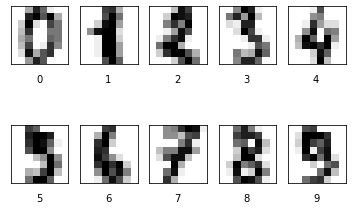

In [6]:
# Vilizating the data
for i in range(1,11):
    plt.subplot(2,5,i)
    plt.imshow(digits.data[i-1].reshape([8,8]),cmap=plt.cm.gray_r)
    plt.text(3,10,str(digits.target[i-1]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [7]:
# Split the data into training set and test set 
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25)

In [8]:
# reformulate the label. 
# If the digit is smaller than 5, the label is 0.
# If the digit is larger than 5, the label is 1.

y_train[y_train < 5 ] = 0
y_train[y_train >= 5] = 1
y_test[y_test < 5] = 0
y_test[y_test >= 5] = 1

In [9]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1347, 64)
(450, 64)
(1347,)
(450,)


#### 3- Architecture of the neural network

![title](network.png)

In [10]:
!pwd

/home/ipfgao/Computing-Intelligence/ipfgao/assignment4


##### Mathematical expression of the algorithm:

For one example $x^{(i)}$:   
 $$ z^{(i)} = w^T * x^{(i)} +b $$   
 $$ y^{(i)} = a^{(i)} = sigmoid(z^{(i)})$$   
 $$L(a^{(i)},y^{(i)}) = -y^{(i)} log(a^{(i)})-(1-y^{(i)})log(1-a^{(i)})$$

The total cost over all training examples:
$$ J = \frac{1}{m}\sum_{i=1}^{m}L(a^{(i)},y^{(i)}) $$

#### 4 - Building the algorithm

##### 4.1- Activation function    
###### Exercise:
Finish the sigmoid funciton 

In [11]:
def sigmoid(z):
    '''
    Compute the sigmoid of z
    Arguments: z -- a scalar or numpy array of any size.
    
    Return:
    s -- sigmoid(z)
    '''
    s =1/(1+ np.exp(-z))
    
    return s

In [12]:
# Test your code 
# The result should be [0.5 0.88079708]
print("sigmoid([0,2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0,2]) = [0.5        0.88079708]


##### 4.1-Initializaing parameters
###### Exercise:
Finishe the initialize_parameters function below

In [20]:
# Random innitialize the parameters

def initialize_parameters(dim):
    '''
    Argument: dim -- size of the w vector  #总共有多少个w
    
    Returns:
    w -- initialized vector of shape (dim,1) #shape(dim,1),表示dim行，1列的向量
    b -- initializaed scalar
    '''
    import random
    w = np.random.randn(dim,1)               #生产dim行，1列的随机数,
    b = random.randint(-1,1)                  #随机数b
    
    assert(w.shape == (dim,1))
    assert(isinstance(b,float) or isinstance(b,int))
    
    return w,b

#### 4.3-Forward and backward propagation

###### Some mathematical expressions
Forward Propagation:   
. X    
. A = $\sigma(w^T*X+b) = (a^{(1)},a^{(2)},...,a^{(m)})$   
. J = $-\frac{1}{m} \sum_{i=1}^{m}(y^{(i)}loga^{(i)}+(1-y^{(i)})log(1-a^{(i)}))$       

Some derivative: 
$$\frac{\partial{J}}{\partial{w}} = \frac{1}{m}X*(A-Y)^T$$   
$$\frac{\partial{J}}{\partial{b}} = \frac{1}{m}\sum_{i=1}^m(a^{(i)}-y^{(i)}) $$

###### Exercise:
Finish the function below:

In [14]:
def propagate(w,b,X,Y):
    '''
    Implement the cost function and its gradient for the propagation
    
    Arguments:
    w - weights
    b - bias
    X - data，类型是np.array
    Y - ground truth
    '''
    m = X.shape[1]                       #列数，样本总数
    A = sigmoid(np.dot(w.T,X)+b)        #w.T,将w转置
    cost = -1/m*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))
    
    dw = 1/m*np.dot(X,(A-Y).T)
    db = 1/m*np.sum(A-Y)
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {'dw':dw,
             'db':db}
    return grads, cost

##### 4.4 -Optimization

###### Exercise:
Minimizing the cost function using gradient descent.   
$$\theta = \theta - \alpha*d\theta$$ where $\alpha$ is the learning rate.

In [15]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    '''
    This function optimize w and b by running a gradient descen algorithm
    
    Arguments:
    w - weights
    b - bias
    X - data
    Y - ground truth
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params - dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    '''
    
    costs = []
    
    for i in range(num_iterations):
        
        grads, cost = propagate(w,b,X,Y)
        
        dw = grads['dw']
        db = grads['db']
        
        w = w-learning_rate*dw
        b = b-learning_rate*db
        
        if i % 100 == 0:
            costs.append(cost)
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w":w,
              "b":b}
    
    grads = {"dw":dw,
             "db":db}
    
    return params, grads, costs

###### Exercise
The previous function will output the learned w and b. We are able to use w and b to predict the labels for a dataset X. Implement the predict() function.    
Two steps to finish this task:   
1. Calculate $\hat{Y} = A = \sigma(w^T*X+b)$   
2. Convert the entries of a into 0 (if activation <= 0.5) or 1 (if activation > 0.5), stores the predictions in a vector Y_prediction. If you wish, you can use an if/else statement in a for loop (though there is also a way to vectorize this).

In [16]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights
    b -- bias 
    X -- data 
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0],1)
    
    A = sigmoid(np.dot(w.T,X)+b)
    #for i in range(A.shape[i]):
    #    None 
    Y_prediction=(A>0.5)+0  
    assert(Y_prediction.shape == (1,m))
    
    return Y_prediction

##### 5- Merge all functions into a model

Congratulations !! You have finished all the necessary components for constructing a model. Now, Let's take the challenge to merge all the implemented function into one model.

In [17]:
def model(X_train, Y_train, X_test, Y_test, num_iterations, learning_rate,print_cost):
    """
    Build the logistic regression model by calling all the functions you have implemented.
    Arguments:
    X_train - training set
    Y_train - training label
    X_test - test set
    Y_test - test label
    num_iteration - hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d - dictionary should contain following information w,b,training_accuracy, test_accuracy,cost
    eg: d = {"w":w,
             "b":b,
             "training_accuracy": traing_accuracy,
             "test_accuracy":test_accuracy,
             "cost":cost}
    """
    #初始话参数
    w=initialize_parameters(X_train.shape[1])[0]
    b=initialize_parameters(X_train.shape[1])[1]
    
    # 
    D=optimize(w,b,X_train.T,Y_train.T,num_iterations,learning_rate,print_cost)
    
    Y_prediction=predict(w, b, X_train.T)
    Y_accuracy=(Y_train-Y_prediction).tolist()[0]#全是0效果才好
    traing_accuracy=Y_accuracy.count(0)/len(Y_accuracy)
    
    Y_prediction=predict(w, b, X_test.T)
    Y_accuracy=(Y_test-Y_prediction).tolist()[0]#全是0效果才好
    test_accuracy=Y_accuracy.count(0)/len(Y_accuracy)

    d = {"w":D[0]["w"],
         "b":D[0]["b"],
         "training_accuracy": traing_accuracy,
         "test_accuracy":test_accuracy,
         "cost":D[2][-1]}
        
    return d

In [21]:
model(X_train,y_train,X_test,y_test,10000,0.01,False)

/home/ipfgao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/home/ipfgao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


{'w': array([[ 6.26983846e-01],
        [ 1.57725886e-01],
        [ 1.78231298e-02],
        [ 5.87790975e-03],
        [ 5.33494033e-02],
        [ 1.27556700e-01],
        [ 1.26735390e-01],
        [ 3.91039168e-01],
        [-1.58997748e+00],
        [-1.62179898e-01],
        [ 1.34945962e-01],
        [ 8.06864811e-02],
        [-5.19387772e-02],
        [-3.07894152e-02],
        [ 1.00369741e-03],
        [-2.16586533e-01],
        [-6.97552346e-01],
        [ 1.23682430e-01],
        [ 1.46818003e-01],
        [-4.92705964e-02],
        [-2.51182737e-01],
        [-1.07531969e-01],
        [-7.22337269e-02],
        [-5.51342344e-01],
        [-1.17012750e+00],
        [-2.41306151e-01],
        [ 5.87278310e-02],
        [ 2.27383811e-01],
        [ 5.15268579e-02],
        [ 1.80983126e-01],
        [-1.47582990e-01],
        [-7.04240794e-01],
        [ 7.90929461e-01],
        [-3.06632353e-01],
        [-1.44918938e-02],
        [ 2.04572826e-01],
        [-9.33014787e-0

### 4.选做题

Congratulations on building your first logistic regression model. It is your time to analyze it further.

##### 4.1 Observe the effect of learning rate on the leraning process.   
Hits: plot the learning curve with different learning rate

In [19]:
model(X_train,y_train,X_test,y_test,10000,0.1,False)

/home/ipfgao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/home/ipfgao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]


{'w': array([[-1.72666802],
        [ 1.2072063 ],
        [ 0.18104579],
        [-0.19768985],
        [ 0.56618531],
        [ 1.14104408],
        [ 1.2881562 ],
        [-1.98040702],
        [ 1.24866642],
        [-1.87061837],
        [ 1.24860261],
        [ 0.80563429],
        [-0.50658115],
        [-0.2080818 ],
        [-0.12582261],
        [ 3.11904679],
        [-0.2529963 ],
        [ 1.23115076],
        [ 1.43538244],
        [-0.4221246 ],
        [-2.2286298 ],
        [-1.00723678],
        [-1.07301654],
        [-3.07158583],
        [-1.62135634],
        [-2.37728014],
        [ 0.42751407],
        [ 2.06115276],
        [ 0.44927008],
        [ 1.78844523],
        [-1.36985136],
        [-0.85382021],
        [ 0.15895955],
        [-2.7150193 ],
        [-0.1913384 ],
        [ 1.89777231],
        [-0.92195932],
        [-0.22050877],
        [ 0.72930981],
        [-0.38267708],
        [-1.12726014],
        [-0.27421911],
        [ 0.95349176],
      

##### 4.2 Observe the effect of iteration_num on the test accuracy.

# Challenge ! ! !

The original data have images labeled 0,1,2,3,4,5,6,7,8,9. In our logistic model, we only detect if the digit in the image is larger or smaller than 5. Now, Let's go for a more challenging problem. Try to use softmax function to build a model to recognize which digits (0,1,2,3,4,5,6,7,8,9) is in the image.

# Congratulations ! You have completed assigment 4. 